The goal of this notebook is to combine some of the best public notebooks into one notebook, creating one ensembled submission file from a total of 4 notebooks.

The notebooks used are:

- https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43

- https://www.kaggle.com/code/yunsuxiaozi/hms-baseline-resnet34d-512-512-inference-6-models

- https://www.kaggle.com/code/andreasbis/hms-inference-lb-0-41

- https://www.kaggle.com/code/nartaa/features-head-starter-lb-0-36

This notebook is based on the work of JIYUANZHANG, found [here](https://www.kaggle.com/code/kitsuha/3-model-ensemble-lb-0-37)

# Model 1

In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

VER = 5

# IF THIS EQUALS NONE, THEN WE TRAIN NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY TRAINED MODELS
LOAD_MODELS_FROM = '/kaggle/input/brain-efficientnet-models-v3-v4-v5/'

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version = 2.13.0
Using 2 GPUs


In [2]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


In [3]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [4]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [5]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 3.03 s, sys: 6.15 s, total: 9.18 s
Wall time: 53.9 s


In [6]:
%%time
READ_EEG_SPEC_FILES = False

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 4.8 s, sys: 8.51 s, total: 13.3 s
Wall time: 1min 5s


In [7]:
import albumentations as albu
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, mode='train',
                 specs = spectrograms, eeg_specs = all_eegs): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X) 
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((len(indexes),128,256,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        img = np.ones((128,256),dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test': 
                r = 0
            else: 
                r = int( (row['min'] + row['max'])//4 )

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img,np.exp(-4),np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j,14:-14,:,k] = img[:,22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j,:,:,4:] = img
                
            if self.mode!='test':
                y[j,] = row[TARGETS]
            
        return X,y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

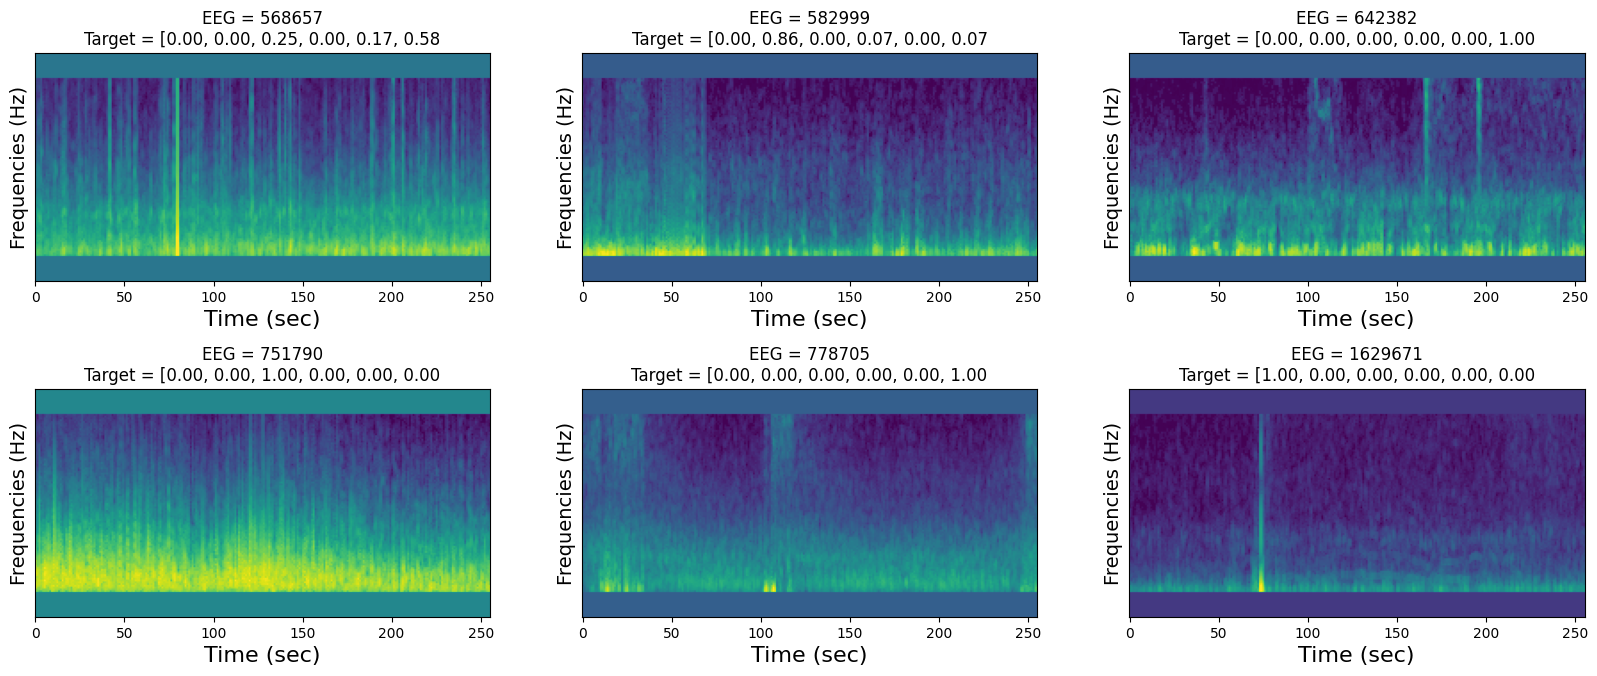

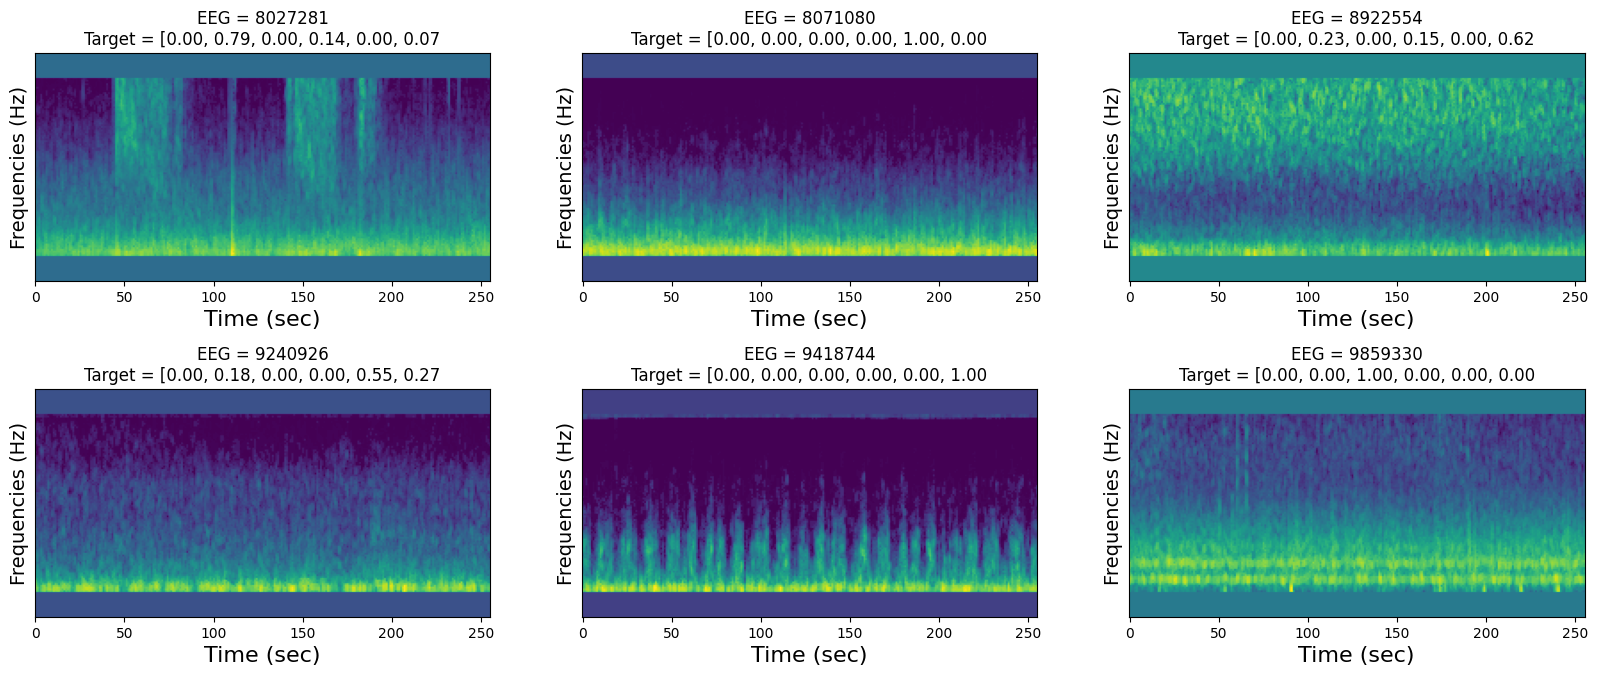

In [8]:
gen = DataGenerator(train, batch_size=32, shuffle=False)
ROWS=2; COLS=3; BATCHES=2

for i,(x,y) in enumerate(gen):
    plt.figure(figsize=(20,8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS,COLS,j*COLS+k+1)
            t = y[j*COLS+k]
            img = x[j*COLS+k,:,:,0][::-1,]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]: tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i==BATCHES-1: break

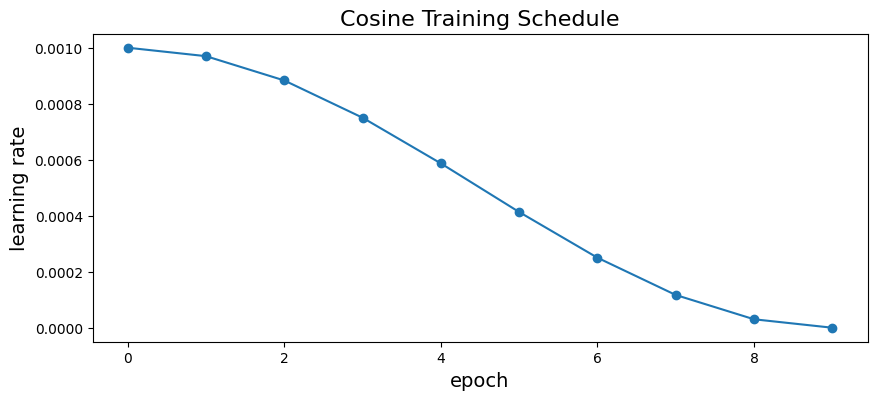

In [9]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS2 = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS2)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Cosine Training Schedule',size=16); plt.show()

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

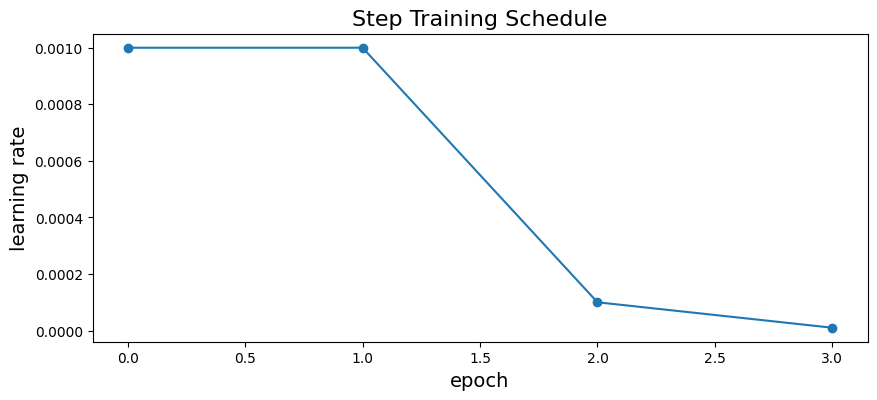

In [10]:
LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 1
LR_STEP_DECAY = 0.1
EVERY = 1
EPOCHS = 4

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//EVERY)
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [11]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)


In [12]:
import efficientnet.tfkeras as efn

def build_model():
    
    inp = tf.keras.Input(shape=(128,256,8))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    
    # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE
    # KAGGLE SPECTROGRAMS
    x1 = [inp[:,:,:,i:i+1] for i in range(4)]
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)
    # EEG SPECTROGRAMS
    x2 = [inp[:,:,:,i+4:i+5] for i in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    # MAKE 512X512X3
    if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
        x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
    elif USE_EEG_SPECTROGRAMS: x = x2
    else: x = x1
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
    
    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt) 
        
    return model

In [13]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32, augment=False)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR])
        model.save_weights(f'EffNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i}.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 28s 402ms/step
#########################
### Fold 2
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 27s 432ms/step
#########################
### Fold 3
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 27s 432ms/step
#########################
### Fold 4
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 27s 429ms/step
#########################
### Fold 5
### train size 13672, valid size 3417
#########################
54/54 [==============================] - 29s 471ms/step


In [14]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)

CV Score KL-Div for EfficientNetB2 = 0.5989355021762731


In [15]:
del all_eegs, spectrograms; gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [16]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values
    
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

In [17]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

Converting Test EEG to Spectrograms...



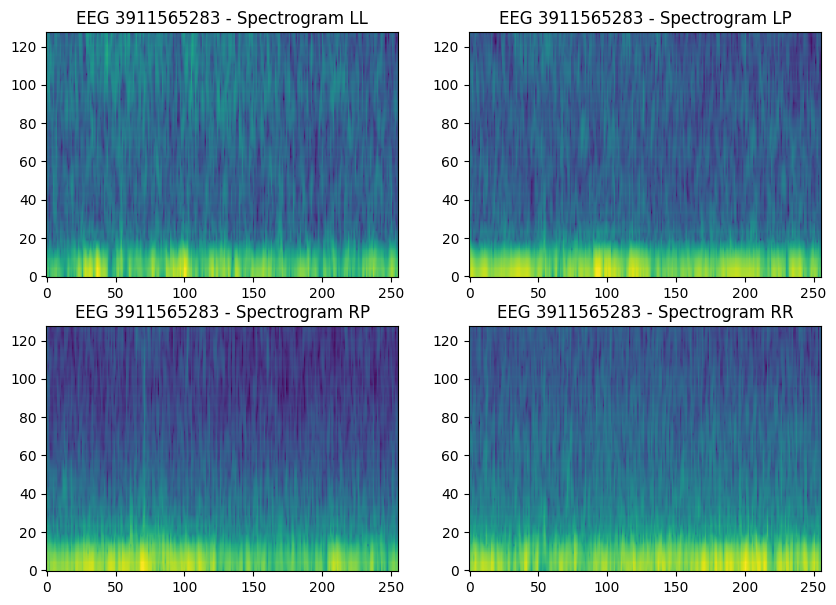

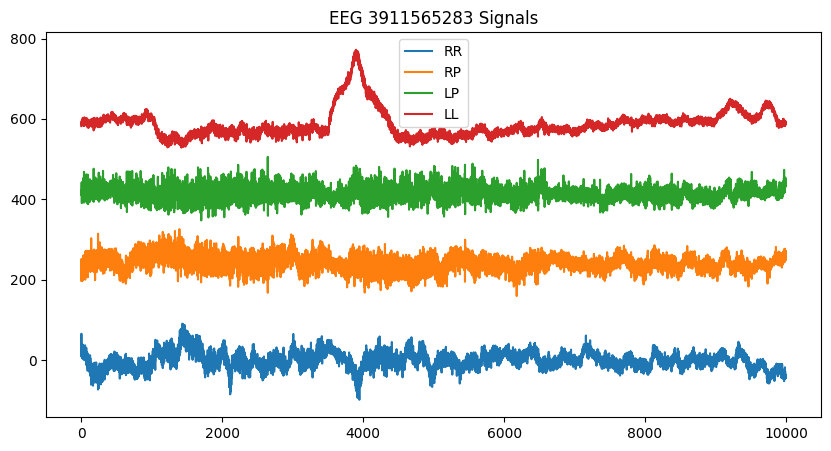


#########################



In [18]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

In [19]:
# INFER EFFICIENTNET ON TEST
preds = []
model = build_model()
test_gen = DataGenerator(test, shuffle=False, batch_size=64, mode='test',
                         specs = spectrograms2, eeg_specs = all_eegs2)

for i in range(5):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'EffNet_v{VER}_f{i}.h5')
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 2s 2s/step
Fold 2
1/1 [==============================] - 0s 48ms/step
Fold 3
1/1 [==============================] - 0s 49ms/step
Fold 4
1/1 [==============================] - 0s 48ms/step
Fold 5
1/1 [==============================] - 0s 46ms/step

Test preds shape (1, 6)


In [20]:
sub1 = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub1[TARGETS] = pred
print('Submission shape',sub1.shape)
sub1.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.169902,0.050157,0.000418,0.371332,0.019669,0.388522


In [21]:
preds_combine = pred
preds_combine

array([[0.16990179, 0.05015718, 0.00041751, 0.3713324 , 0.01966871,
        0.38852242]], dtype=float32)

In [22]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub1.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32

# Model 2

In [23]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import random
import warnings
warnings.filterwarnings('ignore')

In [24]:
class Config:
    seed=2024
    image_transform=transforms.Resize((512, 512))
    num_folds=5

In [25]:
models=[]
for i in range(Config.num_folds):
    model = torch.load(f'/kaggle/input/hms-baseline-resnet34d-512-512-training-5-folds/HMS_resnet_fold{i}.pth')
    models.append(model)
model = torch.load("/kaggle/input/hms-baseline-resnet34d-512-512-training/HMS_resnet.pth")
models.append(model)

In [26]:
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True#将cuda加速的随机数生成器设为确定性模式
    torch.backends.cudnn.benchmark = True#关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
    torch.manual_seed(seed)#pytorch的随机种子
    np.random.seed(seed)#numpy的随机种子
    random.seed(seed)#python内置的随机种子
seed_everything(Config.seed)

In [27]:
test_df=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
submission=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
submission=submission.merge(test_df,on='eeg_id',how='left')
submission['path']=submission['spectrogram_id'].apply(lambda x: "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"+str(x)+".parquet" )
submission.head()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,patient_id,path
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,853520,6885,/kaggle/input/hms-harmful-brain-activity-class...


In [28]:
paths=submission['path'].values
test_preds=[]
for path in paths:
    eps=1e-6
    data=pd.read_parquet(path)
    #这里最小值是0,故用-1填充.第一列是时间列,故去掉 ,行是不同列,列是时间
    data = data.fillna(-1).values[:,1:].T
    #选取一段时间的数据进行训练
    data=data[:,0:300]#(400,300)
    data=np.clip(data,np.exp(-6),np.exp(10))#最大值为89209464.0
    data= np.log(data)#对数变换
    #对数据进行归一化
    data_mean=data.mean(axis=(0,1))
    data_std=data.std(axis=(0,1))
    data=(data-data_mean)/(data_std+eps)
    data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
    data=Config.image_transform(data_tensor)
    test_pred=[]
    for model in models:
        model.eval()
        with torch.no_grad():
            pred=F.softmax(model(data.unsqueeze(0)))[0]
            pred=pred.detach().cpu().numpy()
        test_pred.append(pred)
    test_pred=np.array(test_pred).mean(axis=0)
    test_preds.append(test_pred)
test_preds=np.array(test_preds)
test_preds

array([[0.05919053, 0.09752721, 0.00133264, 0.4303651 , 0.02627888,
        0.38530564]], dtype=float32)

In [29]:
sub2=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    sub2[f'{labels[i]}_vote']=test_preds[:,i]
sub2.head()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.059191,0.097527,0.001333,0.430365,0.026279,0.385306


# Model 3

In [30]:
# Importing essential libraries
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

# PyTorch for deep learning
import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F

# torchvision for image processing and augmentation
import torchvision.transforms as transforms

# Suppressing minor warnings to keep the output clean
warnings.filterwarnings('ignore', category=Warning)

# Reclaim memory no longer in use.
gc.collect()

18

In [31]:
class Config:
    seed=42
    image_transform=transforms.Resize((512, 512))
    num_folds=5
    
# Set the seed for reproducibility across multiple libraries
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

In [32]:
# Load and store the trained models for each fold into a list
models = []

# Load ResNet34d
for i in range(Config.num_folds):
    # Create the same model architecture as during training
    model_resnet = timm.create_model('resnet34d', pretrained=False, num_classes=6, in_chans=1)
    
    # Load the trained weights from the corresponding file
    model_resnet.load_state_dict(torch.load(f'/kaggle/input/resnet34d/hms-train-resnet34d/resnet34d_fold{i}.pth', map_location=torch.device('cpu')))
    
    # Append the loaded model to the models list
    models.append(model_resnet)

# Reclaim memory no longer in use.
gc.collect()

# Load EfficientNetB0
for j in range(Config.num_folds):
    # Create the same model architecture as during training
    model_effnet_b0 = timm.create_model('efficientnet_b0', pretrained=False, num_classes=6, in_chans=1)
    
    # Load the trained weights from the corresponding file
    model_effnet_b0.load_state_dict(torch.load(f'/kaggle/input/efficientnetb0/hms-train-efficientnetb0/efficientnet_b0_fold{j}.pth', map_location=torch.device('cpu')))
    
    # Append the loaded model to the models list
    models.append(model_effnet_b0)
    
# Reclaim memory no longer in use.
gc.collect()
    
# Load EfficientNetB1
for k in range(Config.num_folds):
    # Create the same model architecture as during training
    model_effnet_b1 = timm.create_model('efficientnet_b1', pretrained=False, num_classes=6, in_chans=1)
    
    # Load the trained weights from the corresponding file
    model_effnet_b1.load_state_dict(torch.load(f'/kaggle/input/efficientnetb1/hms-train-efficientnetb1/efficientnet_b1_fold{k}.pth', map_location=torch.device('cpu')))
    
    # Append the loaded model to the models list
    models.append(model_effnet_b1)

# Reclaim memory no longer in use.
gc.collect()

18

In [33]:
# Load test data and sample submission dataframe
test_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
submission = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")

# Merge the submission dataframe with the test data on EEG IDs
submission = submission.merge(test_df, on='eeg_id', how='left')

# Generate file paths for each spectrogram based on the EEG data in the submission dataframe
submission['path'] = submission['spectrogram_id'].apply(lambda x: f"/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{x}.parquet")

# Display the first few rows of the submission dataframe
display(submission.head())

# Reclaim memory no longer in use
gc.collect()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,patient_id,path
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,853520,6885,/kaggle/input/hms-harmful-brain-activity-class...


0

In [34]:
# Define the weights for each model
weight_resnet34d = 0.26
weight_effnetb0 = 0.48
weight_effnetb1 = 0.26

# Get file paths for test spectrograms
paths = submission['path'].values
test_predss = []

# Generate predictions for each spectrogram using all models
for path in paths:
    eps = 1e-6
    # Read and preprocess spectrogram data
    data = pd.read_parquet(path)
    data = data.fillna(-1).values[:, 1:].T
    data = np.clip(data, np.exp(-6), np.exp(10))
    data = np.log(data)
    
    # Normalize the data
    data_mean = data.mean(axis=(0, 1))
    data_std = data.std(axis=(0, 1))
    data = (data - data_mean) / (data_std + eps)
    data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
    data = Config.image_transform(data_tensor)

    test_pred = []
    
    # Generate predictions using all models
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = F.softmax(model(data.unsqueeze(0)))[0]
            pred = pred.detach().cpu().numpy()
        test_pred.append(pred)
        
    # Combine predictions from all models using weighted voting
    weighted_pred = weight_resnet34d * np.mean(test_pred[:Config.num_folds], axis=0) + \
                     weight_effnetb0 * np.mean(test_pred[Config.num_folds:2*Config.num_folds], axis=0) + \
                     weight_effnetb1 * np.mean(test_pred[2*Config.num_folds:], axis=0)
    
    test_predss.append(weighted_pred)

# Convert the list of predictions to a NumPy array for further processing
test_predss = np.array(test_predss)

# Reclaim memory no longer in use
gc.collect()

0

In [35]:
test_predss

array([[0.03440302, 0.10387928, 0.00081764, 0.37150744, 0.0108148 ,
        0.47857773]], dtype=float32)

# Model 4

In [36]:
import os
import tensorflow as tf
import tensorflow
import tensorflow.keras.backend as K
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

LOAD_BACKBONE_FROM = '/kaggle/input/efficientnetb-tf-keras/EfficientNetB2.h5'
LOAD_MODELS_FROM = '/kaggle/input/features-head-starter-models/'
VER = 35
DATA_TYPE = 'both' # both|eeg|kaggle|raw
TEST_MODE = False
submission = True

# Setup for ensemble
ENSEMBLE = True
LBs = [0.39,0.41,0.43,0.52] # for weighted ensemble we use LBs of each model
VERK = 33.2 # Kaggle's spectrogram model version
VERB = 35 # Kaggle's and EEG's spectrogram model version
VERE = 34 # EEG's spectrogram model version
VERR = 36 # EEG's raw wavenet model version

np.random.seed(42)

# USE SINGLE GPU, MULTIPLE GPUS 
gpus = tf.config.list_physical_devices('GPU')
# WE USE MIXED PRECISION
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
if len(gpus)>1:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')

Using 2 GPUs


In [37]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}

def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        data[:,j] = x

    return data

def add_kl(data):
    import torch
    labels = data[TARGETS].values + 1e-5

    # compute kl-loss with uniform distribution by pytorch
    data['kl'] = torch.nn.functional.kl_div(
        torch.log(torch.tensor(labels)),
        torch.tensor([1 / 6] * 6),
        reduction='none'
    ).sum(dim=1).numpy()
    return data

if not submission:
    train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    META = ['spectrogram_id','spectrogram_label_offset_seconds','patient_id','expert_consensus']
    train = train.groupby('eeg_id')[META+TARGETS
                           ].agg({**{m:'first' for m in META},**{t:'sum' for t in TARGETS}}).reset_index() 
    train[TARGETS] = train[TARGETS]/train[TARGETS].values.sum(axis=1,keepdims=True)
    train.columns = ['eeg_id','spec_id','offset','patient_id','target'] + TARGETS
    train = add_kl(train)
    print(train.head(1).to_string())

In [38]:
%%time
if not submission:
    # FOR TESTING SET READ_FILES TO TRUE
    if TEST_MODE:
        train = train.sample(500,random_state=42).reset_index(drop=True)
        spectrograms = {}
        for i,e in enumerate(train.spec_id.values):
            if i%100==0: print(i,', ',end='')
            x = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/{e}.parquet')
            spectrograms[e] = x.values
        all_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = np.load(f'/kaggle/input/eeg-spectrograms/EEG_Spectrograms/{e}.npy')
            all_eegs[e] = x
        all_raw_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = eeg_from_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{e}.parquet')              
            all_raw_eegs[e] = x
    else:
        spectrograms = None
        all_eegs = None
        all_raw_eegs = None
        if DATA_TYPE=='both' or DATA_TYPE=='kaggle':
            spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()
        if DATA_TYPE=='both' or DATA_TYPE=='eeg':
            all_eegs = np.load('/kaggle/input/eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
        if DATA_TYPE=='raw':
            all_raw_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [39]:
import albumentations as albu
from scipy.signal import butter, lfilter

class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data, specs=None, eeg_specs=None, raw_eegs=None, augment=False, mode='train', data_type=DATA_TYPE): 
        self.data = data
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.on_epoch_end()
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        X, y = self.data_generation(index)
        if self.augment: X = self.augmentation(X)
        return X, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
                
    def on_epoch_end(self):
        if self.mode=='train': 
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def data_generation(self, index):
        if self.data_type == 'both':
            X,y = self.generate_all_specs(index)
        elif self.data_type == 'eeg' or self.data_type == 'kaggle':
            X,y = self.generate_specs(index)
        elif self.data_type == 'raw':
            X,y = self.generate_raw(index)

        return X,y
    
    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
            
        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]
        
        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in range(4)]
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)
            
        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,2]
        X[200+56:300+56,:256,1] = img[:,22:-22,1]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,1]
        X[200+56:300+56,256:,1] = img[:,22:-22,2]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
            
        if self.data_type == 'eeg':
            img = self.eeg_specs[row.eeg_id]
        elif self.data_type == 'kaggle':
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in range(4)]
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            
            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,2]
        X[200+56:300+56,:256,1] = img[:,22:-22,1]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,1]
        X[200+56:300+56,256:,1] = img[:,22:-22,2]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_raw(self,index):
        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0
            
        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
                
        return X,y
        
    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data
    
    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']
            
    def augmentation(self, img):
        composition = albu.Compose([
                albu.HorizontalFlip(p=0.4)
            ])
        return composition(image=img)['image']

In [40]:
if not submission and DATA_TYPE!='raw':
    gen = DataGenerator(train, augment=False, specs=spectrograms, eeg_specs=all_eegs, data_type=DATA_TYPE)
    for x,y in gen:
        break
    plt.imshow(x[:,:,0])
    plt.title(f'Target = {y.round(1)}',size=12)
    plt.yticks([])
    plt.ylabel('Frequencies (Hz)',size=12)
    plt.xlabel('Time (sec)',size=12)
    plt.show()
    
if not submission and DATA_TYPE=='raw':
    gen = DataGenerator(train, raw_eegs=all_raw_eegs, data_type=DATA_TYPE)
    for x,y in gen:
        plt.figure(figsize=(20,4))
        offset = 0
        for j in range(x.shape[-1]):
            if j!=0: offset -= x[:,j].min()
            plt.plot(range(2_000),x[:,j]+offset,label=f'feature {j+1}')
            offset += x[:,j].max()
        plt.legend()
        plt.show()
        break

In [41]:
if not submission:

    def lrfn(epoch):
        return [1e-3,1e-3,1e-4,1e-4][epoch]

    LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    
    def lrfn2(epoch):
        return [1e-5,1e-5,1e-6][epoch]

    LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose = True)

In [42]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def build_model():  
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')    
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=output)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

def score(y_true, y_pred):
    kl = tf.keras.metrics.KLDivergence()
    return kl(y_true, y_pred)

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

def build_wave_model():
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 3, 12)
    x = wave_block(x, 16, 3, 8)
    x = wave_block(x, 32, 3, 4)
    x = wave_block(x, 64, 3, 1)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

In [43]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

if not submission:
    all_oof = []
    all_true = []
    losses = []
    val_losses = []
    total_hist = {}

    gkf = GroupKFold(n_splits=5)
    for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
        
        print('#'*25)
        print(f'### Fold {i+1}')
        
        data, val = train.iloc[train_index],train.iloc[valid_index]
        train_gen = DataGenerator(data, augment=False, specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs)
        valid_gen = DataGenerator(val, mode='valid', specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs)
        data, val = data[data['kl']<5.5],val[val['kl']<5.5]
        train_gen2 = DataGenerator(data, augment=False, specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs)
        valid_gen2 = DataGenerator(val, mode='valid', specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs)
        in_shape = (2000,8) if DATA_TYPE=='raw' else (512,512,3)
        EPOCHS = 4
        BATCH_SIZE_PER_REPLICA = 32
        BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

        train_dataset = tf.data.Dataset.from_generator(generator=train_gen, 
                                                   output_signature=(tf.TensorSpec(shape=in_shape, dtype=tf.float32),
                                                                     tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        val_dataset = tf.data.Dataset.from_generator(generator=valid_gen, 
                                                   output_signature=(tf.TensorSpec(shape=in_shape, dtype=tf.float32),
                                                                     tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        train_dataset2 = tf.data.Dataset.from_generator(generator=train_gen2, 
                                                   output_signature=(tf.TensorSpec(shape=in_shape, dtype=tf.float32),
                                                                     tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        val_dataset2 = tf.data.Dataset.from_generator(generator=valid_gen2, 
                                                   output_signature=(tf.TensorSpec(shape=in_shape, dtype=tf.float32),
                                                                     tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
          
        print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
        print('#'*25)
        
        K.clear_session()
        with strategy.scope():
            if DATA_TYPE=='raw':
                model = build_wave_model()
            else:
                model = build_model()
        
        hist = model.fit(train_dataset, validation_data = val_dataset, 
                         epochs=EPOCHS, callbacks=[LR])
        print(f'### seconds stage train size {len(data)}, valid size {len(val)}')
        print('#'*25)
        hist2 = model.fit(train_dataset2, validation_data = val_dataset, 
                         epochs=3, callbacks=[LR2])
        losses.append(hist.history['loss']+hist2.history['loss'])
        val_losses.append(hist.history['val_loss']+hist2.history['val_loss'])
        K.clear_session()
        with strategy.scope():
            model.save_weights(f'model_{DATA_TYPE}_{VER}_{i}.weights.h5')
        oof = model.predict(val_dataset, verbose=1)
        all_oof.append(oof)
        all_true.append(train.iloc[valid_index][TARGETS].values)    
        del model, oof
        gc.collect()
        
    total_hist['loss'] = np.mean(losses,axis=0)
    total_hist['val_loss'] = np.mean(val_losses,axis=0)
    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)
    plot_hist(total_hist)
    print('#'*25)
    print(f'CV KL SCORE: {score(all_true,all_oof)}')

In [44]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0
                
            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300, 
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)
            
            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.show()
        
    return img

In [45]:
if submission:
    test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
    print('Test shape',test.shape)
    test.head()

Test shape (1, 3)


In [46]:
# READ ALL SPECTROGRAMS
if submission:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
    files2 = os.listdir(PATH2)
    print(f'There are {len(files2)} test spectrogram parquets')
    
    spectrograms2 = {}
    for i,f in enumerate(files2):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH2}{f}')
        name = int(f.split('.')[0])
        spectrograms2[name] = tmp.iloc[:,1:].values
    
    # RENAME FOR DATA GENERATOR
    test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

In [47]:
# READ ALL EEG SPECTROGRAMS
if submission:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
    DISPLAY = 0
    EEG_IDS2 = test.eeg_id.unique()
    all_eegs2 = {}

    print('Converting Test EEG to Spectrograms...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):
        
        # CREATE SPECTROGRAM FROM EEG PARQUET
        img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
        all_eegs2[eeg_id] = img

Converting Test EEG to Spectrograms...



In [48]:
# READ ALL RAW EEG SIGNALS
if submission :
    all_raw_eegs2 = {}
    EEG_IDS2 = test.eeg_id.unique()
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

    print('Processing Test EEG parquets...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):
        
        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH2}{eeg_id}.parquet')
        all_raw_eegs2[eeg_id] = data

Processing Test EEG parquets...



In [49]:
# Submission ON TEST without ensemble
if submission and not ENSEMBLE:
    preds = []
    
    if DATA_TYPE=='raw':
        test_gen = DataGenerator(test, mode='test', raw_eegs=all_raw_eegs2)
        in_shape = (2000,8)
    else:
        test_gen = DataGenerator(test, mode='test', specs = spectrograms2, eeg_specs = all_eegs2)
        in_shape = (512,512,3)
    
    test_dataset = tf.data.Dataset.from_generator(generator=test_gen, 
                                               output_signature=(tf.TensorSpec(shape=in_shape, dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
    if DATA_TYPE=='raw':
        model = build_wave_model()
    else:
        model = build_model()

    for i in range(5):
        print(f'Fold {i+1}')
        model.load_weights(f'{LOAD_MODELS_FROM}model_{DATA_TYPE}_{VER}_{i}.weights.h5')
        pred = model.predict(test_dataset, verbose=1)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)

In [50]:
# Submission ON TEST with ensemble
if submission and ENSEMBLE:
    preds = []
    test_gen_kaggle = DataGenerator(test, mode='test', data_type='kaggle', specs = spectrograms2, eeg_specs = all_eegs2)
    test_dataset_kaggle = tf.data.Dataset.from_generator(generator=test_gen_kaggle, 
                                               output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
    test_gen_both = DataGenerator(test, mode='test', data_type='both', specs = spectrograms2, eeg_specs = all_eegs2)
    test_dataset_both = tf.data.Dataset.from_generator(generator=test_gen_both, 
                                               output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)

    test_gen_eeg = DataGenerator(test, mode='test', data_type='eeg', specs = spectrograms2, eeg_specs = all_eegs2)
    test_dataset_eeg = tf.data.Dataset.from_generator(generator=test_gen_eeg, 
                                               output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
    test_gen_raw = DataGenerator(test, mode='test', data_type='raw', raw_eegs=all_raw_eegs2)
    test_dataset_raw = tf.data.Dataset.from_generator(generator=test_gen_raw, 
                                               output_signature=(tf.TensorSpec(shape=(2000,8), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
 
    # LB SCORE FOR EACH MODEL
    lbs = 1 - np.array(LBs)
    weights = lbs/lbs.sum()
    model = build_model()
    model_wave = build_wave_model()

    for i in range(5):
        print(f'Fold {i+1}')
        
        model.load_weights(f'{LOAD_MODELS_FROM}model_kaggle_{VERK}_{i}.weights.h5')
        pred_kaggle = model.predict(test_dataset_kaggle, verbose=1)
        
        model.load_weights(f'{LOAD_MODELS_FROM}model_both_{VERB}_{i}.weights.h5')
        pred_both = model.predict(test_dataset_both, verbose=1)
        
        model.load_weights(f'{LOAD_MODELS_FROM}model_eeg_{VERE}_{i}.weights.h5')
        pred_eeg = model.predict(test_dataset_eeg, verbose=1)
        
        model_wave.load_weights(f'{LOAD_MODELS_FROM}model_raw_{VERR}_{i}.weights.h5')
        pred_raw = model_wave.predict(test_dataset_raw, verbose=1)
        
        pred = np.array([pred_both,pred_eeg,pred_kaggle,pred_raw])
        pred = np.average(pred,axis=0,weights=weights)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 13s 13s/step
Fold 2
1/1 [==============================] - 0s 131ms/step
Fold 3
1/1 [==============================] - 0s 124ms/step
Fold 4
1/1 [==============================] - 0s 121ms/step
Fold 5
1/1 [==============================] - 0s 115ms/step
Test preds shape (1, 6)


In [51]:
'''
if submission:
    sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
    sub[TARGETS] = pred
    sub.to_csv('submission.csv',index=False)
    print('Submissionn shape',sub.shape)
    print()
    print(sub.head().to_string())
'''

"\nif submission:\n    sub = pd.DataFrame({'eeg_id':test.eeg_id.values})\n    sub[TARGETS] = pred\n    sub.to_csv('submission.csv',index=False)\n    print('Submissionn shape',sub.shape)\n    print()\n    print(sub.head().to_string())\n"

In [52]:
'''
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
if submission:
    print(sub.iloc[:,-6:].sum(axis=1).to_string())
'''

'\n# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE\nif submission:\n    print(sub.iloc[:,-6:].sum(axis=1).to_string())\n'

# Submission

In [53]:
submission=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    submission[f'{labels[i]}_vote']=(test_preds[:,i]*0.05 + preds_combine[:, i]*0.05 + test_predss[:, i]*0.25 + pred[:, i] * 0.65)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.097704,0.061784,0.000696,0.394823,0.023418,0.421574


In [54]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
submission.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float64

In [55]:
# delete this code
#tempz=pd.read_csv("/kaggle/working/submission.csv")

#tempz.iloc[0, 1] = 0.098192
#tempz.iloc[0, 2] = 0.058772
#tempz.iloc[0, 3] = 0.000671
#tempz.iloc[0, 4] = 0.395016
#tempz.iloc[0, 5] = 0.023945
#tempz.iloc[0, 6] = 0.423405

#tempz.to_csv("/kaggle/working/submission.csv", index=False)
#display(tempz.head())

In [56]:
import pandas as pd

    
# Read the CSV file
finalrounding = pd.read_csv("/kaggle/working/submission.csv")

seizure_vote_value = finalrounding.iloc[0, 1]

lpd_vote_value = finalrounding.iloc[0, 2]

gpd_vote_value = finalrounding.iloc[0, 3]

lrda_vote_value = finalrounding.iloc[0, 4]

grda_vote_value = finalrounding.iloc[0, 5]

other_vote_value = finalrounding.iloc[0, 6]

buffer_value = 0.0

if (seizure_vote_value < 0.06):
    buffer_value = buffer_value + seizure_vote_value
    finalrounding.iloc[0, 1] = 0
    seizure_vote_value = 0
    
if (lpd_vote_value < 0.06):
    buffer_value = buffer_value + lpd_vote_value
    finalrounding.iloc[0, 2] = 0
    lpd_vote_value = 0
    
if (gpd_vote_value < 0.06):
    buffer_value = buffer_value + gpd_vote_value
    finalrounding.iloc[0, 3] = 0
    gpd_vote_value = 0
    
if (lrda_vote_value < 0.06):
    buffer_value = buffer_value + lrda_vote_value
    finalrounding.iloc[0, 4] = 0
    lrda_vote_value = 0
    
if (grda_vote_value < 0.06):
    buffer_value = buffer_value + grda_vote_value
    finalrounding.iloc[0, 5] = 0
    grda_vote_value = 0
    
if (other_vote_value < 0.06):
    buffer_value = buffer_value + other_vote_value
    finalrounding.iloc[0, 6] = 0
    other_vote_value = 0

vote_dict = {
    'var1': seizure_vote_value,
    'var2': lpd_vote_value,
    'var3': gpd_vote_value,  
    'var4': lrda_vote_value,
    'var5': grda_vote_value
}

biggest_var_name = max(vote_dict, key=vote_dict.get)
biggest_value = vote_dict[biggest_var_name]

if (biggest_var_name == 'var1'):
    finalrounding.iloc[0, 1] += buffer_value
    
if (biggest_var_name == 'var2'):
    finalrounding.iloc[0, 2] += buffer_value
    
if (biggest_var_name == 'var3'):
    finalrounding.iloc[0, 3] += buffer_value
    
if (biggest_var_name == 'var4'):
    finalrounding.iloc[0, 4] += buffer_value
    
if (biggest_var_name == 'var5'):
    finalrounding.iloc[0, 5] += buffer_value

finalrounding.to_csv("/kaggle/working/submission.csv", index=False)
finalrounding.iloc[:,-6:].sum(axis=1)
display(finalrounding.head())

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.097704,0.061784,0.0,0.418938,0.0,0.421574
